In [1]:
import pandas as pd
import sqlite3

path = '../../Welcome-Centre-DataCorps-Data/ClientDatabaseStructure.mdb.sqlite'
con = sqlite3.connect(path)

In [2]:
referrals = pd.read_sql("""select * from Referral
left join ReferralStatus on ReferralStatus.ReferralStatusId = Referral.StatusId
left join Ethnicity on Referral.EthnicityId = Ethnicity.EthnicityID
left join Locality on Referral.AddressLocalityId = Locality.LocalityId
left join ClientAddressType on Referral.AddressTypeId = ClientAddressType.ClientAddressTypeID
left join ReferralAgency on Referral.ReferralAgencyId = ReferralAgency.ReferralAgencyId;""", con)
referrals = referrals.set_index('ReferralInstanceId')

In [3]:
clients = pd.read_sql("""select * from Client
left join Ethnicity on Client.ClientEthnicityID = Ethnicity.EthnicityID
left join Country on Client.ClientCountryID = Country.CountryId
left join ResidencyStatus on Client.ClientResidencyId = ResidencyStatus.ResidencyId
left join ClientAddressType on Client.ClientAddressTypeID = ClientAddressType.ClientAddressTypeID
left join Locality on Client.AddressLocalityId = Locality.LocalityId""", con)
clients = clients.set_index('ClientId')

In [4]:
table_sql = """select * from ReferralBenefit
  inner join BenefitType on BenefitType.BenefitTypeId = ReferralBenefit.BenefitTypeId;
select * from ReferralDietaryRequirements
  inner join DietaryRequirements on ReferralDietaryRequirements.DietaryRequirementsID = DietaryRequirements.DietaryRequirementsID;
select * from ReferralDocument
  inner join DocumentEvidence on ReferralDocument.ReferralDocumentId = DocumentEvidence.DocumentEvidenceId;
select * from ReferralDomesticCircumstances
  inner join DomesticCircumstances on DomesticCircumstances.DomesticCircumstancesID = ReferralDomesticCircumstances.DomesticCircumstancesID;
select * from ReferralIssue
  inner join ClientIssueCodes on ClientIssueCodes.ClientIssueId = ReferralIssue.ClientIssueID;
select * from ReferralReason
  inner join ReferralReasonCodes on ReferralReasonCodes.ReferralReasonId = ReferralReason.ReferralReasonID;"""
table_names = [t.split(' ')[3].strip() for t in table_sql.split(';')[:-1]]
tables = {table_names[i]: pd.read_sql(t.strip(), con) for i, t in enumerate(table_sql.split(';')[:-1])}

In [5]:
column_mapping = {
    'ReferralIssue': 'ClientIssueDescription',
    'ReferralBenefit': 'BenefitTypeName',
    'ReferralReason': 'ReferralReasonDescription',
    'ReferralDietaryRequirements': 'DietaryRequirementsDescription',
    'ReferralDomesticCircumstances': 'DomesticCircumstancesDescription',
    'ReferralDocument': 'DocumentEvidenceDescription'
}

In [7]:
flat_tables = {t: tables[t].groupby([tables[t].iloc[:,0], column_mapping[t]]).size().unstack().add_prefix(t + '_') for t in tables}

In [8]:
for t in flat_tables:
    referrals = referrals.merge(flat_tables[t], left_index=True, right_index=True, how='left')

In [10]:
referrals.to_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')
clients.to_csv('../../Welcome-Centre-DataCorps-Data/clients.csv')

In [11]:
referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])
referrals = referrals.assign(days_since=(referrals['ReferralTakenDate']-referrals['ReferralTakenDate'].min()).dt.days)
diffs = referrals.sort_values('ReferralTakenDate').groupby('ClientId')['days_since'].diff()
referrals['time_diff'] = diffs

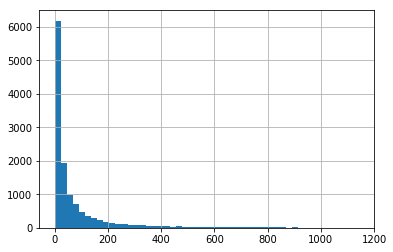

In [123]:
%matplotlib inline
diffs.hist(bins=50)

In [130]:
referrals.columns

Index(['StatusId', 'ReferralOnHold', 'ReferralTakenDate', 'ReferralReadyDate',
       'ReferralCollectedDate', 'ReferralWorkerID', 'ReferralPreparedWorkerId',
       'ReferralHandedWorkerId', 'ClientId', 'PartnerName', 'PartnerId',
       'LivingWithPartner', 'DependantDetails', 'DependantNumber',
       'EthnicityId', 'AddressLocalityId', 'AddressTypeId', 'ReferralAgencyId',
       'ReferralAgencyWorkerName', 'ReferralAgencyTelephoneNumber',
       'DietaryExtraNotes', 'ReferralNotes', 'UpdateTimeStamp',
       'ReferralStatusId', 'ReferralStatusDescription', 'OrderNo', 'Enabled',
       'EthnicityID', 'EthnicityDescription', 'OrderNo', 'Enabled',
       'LocalityId', 'LocalityDescription', 'OrderNo', 'Enabled',
       'ClientAddressTypeID', 'ClientAddressTypeDescription', 'OrderNo',
       'Enabled', 'ReferralAgencyID', 'ReferralAgencyName',
       'ReferralAgencyShortName', 'AddressLine1', 'AddressLine2',
       'AddressLocalityId', 'AddressLine4', 'AddressPostCode',
       'Referra

In [107]:
referrals.sort_values('ReferralTakenDate').groupby('ClientId').last().reset_index()

,ClientId,StatusId,ReferralOnHold,ReferralTakenDate,ReferralReadyDate,ReferralCollectedDate,ReferralWorkerID,ReferralPreparedWorkerId,ReferralHandedWorkerId,PartnerName,...,AddressLine1,AddressLine2,AddressLocalityId,AddressLine4,AddressPostCode,ReferralContactName,ReferralContactNumber,ReferralContactEmail,ReferralAgencyNotes,Enabled
0,2,3,0,05/16/14 00:00:00,05/19/14 12:02:00,05/19/14 12:02:00,3,3.0,3.0,O,...,None,None,NaN,None,None,None,None,None,None,1
1,3,3,0,01/14/14 00:00:00,01/14/14 00:00:00,01/14/14 00:00:00,4,NaN,NaN,None,...,None,None,NaN,None,None,Lisa Omeroyd,None,None,None,1
2,4,3,0,01/15/14 00:00:00,01/15/14 00:00:00,01/15/14 00:00:00,4,NaN,NaN,None,...,None,None,NaN,None,None,None,None,None,None,1
3,5,5,0,12/16/14 15:10:00,12/16/14 00:00:00,None,1,1.0,NaN,None,...,None,None,NaN,None,None,Kay,01484 543977,None,None,1
4,7,3,0,01/16/14 00:00:00,01/16/14 00:00:00,01/16/14 00:00:00,4,NaN,NaN,None,...,None,None,NaN,None,None,None,01484 414782,None,None,1
5,8,3,0,04/20/15 13:10:00,04/20/15 15:02:00,04/20/15 15:02:00,10,5.0,5.0,K,...,None,None,NaN,None,None,Shabaz,None,None,None,1
6,9,3,0,03/18/14 00:00:00,03/18/14 00:00:00,03/18/14 00:00:00,4,NaN,NaN,None,...,None,None,NaN,None,None,None,01484 421461,None,None,1
7,10,3,0,12/02/16 14:09:00,12/02/16 15:29:00,12/02/16 15:29:00,8,26.0,26.0,None,...,None,None,NaN,None,None,Keira,01484 448670,None,None,1
8,11,3,0,02/06/14 00:00:00,02/06/14 00:00:00,02/06/14 00:00:00,4,NaN,NaN,None,...,None,None,NaN,None,None,Kay,01484 543977,None,None,1
9,13,3,0,09/11/15 10:25:00,09/11/15 00:00:00,09/11/15 00:00:00,1,1.0,1.0,None,...,None,None,NaN,None,None,None,01484 414782,None,None,1


In [69]:
referrals.groupby(referrals['ClientId'].iloc[:,0]).size().sort_values()

ClientId
3158      1
3593      1
3595      1
3597      1
3598      1
3600      1
3610      1
3616      1
3617      1
3618      1
3619      1
3621      1
3590      1
3622      1
3627      1
3632      1
3634      1
3635      1
3637      1
3638      1
3639      1
3641      1
3642      1
3644      1
3646      1
3624      1
3648      1
3588      1
3584      1
3525      1
       ... 
1285     27
870      27
163      28
2908     28
837      30
4483     31
4637     31
133      32
241      32
4880     32
3378     32
964      33
5201     33
560      33
1030     34
344      34
322      35
738      35
1225     35
2918     36
187      39
594      40
839      40
4267     40
1391     43
4606     43
749      49
3711     56
2890     91
287     108
Length: 5376, dtype: int64

In [63]:
referrals.shape

(17980, 204)

In [60]:
(referrals.count() / len(referrals)).sort_values()*100

DietaryNotes                             0.000000
OrderNo                                  0.000000
ReferralContactEmail                     0.000000
PreviousAddressList                      0.000000
AddressLine4                             0.000000
AddressLine2                             0.000000
AddressLine1                             0.000000
ClientNickName                           0.000000
OrderNo:3                                0.000000
ReferralAgencyNotes                      0.005562
AddressLine2                             0.011123
fleeing domestic violence                0.011123
Healthy Eating Vouchers                  0.011123
AddressLine4                             0.016685
AddressPostCode                          0.038932
AddressLocalityId                        0.044494
meltham food service delivery            0.050056
Benefits - New/Changed Benefits Cap      0.061179
Coeliac                                  0.061179
Vegan                                    0.061179


In [84]:
referrals.to_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')

In [94]:
non_id = referrals[referrals.columns[referrals.columns.str.lower().str.slice(-2) != 'id']]

In [174]:
last = referrals.reset_index().groupby('ClientId').last().set_index('ReferralInstanceId')

In [176]:
X = flat_tables['ReferralReason'] > 0
y = X.index.isin(last.index)
y = referrals.loc[X.index]['time_diff']

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [158]:
aggregated = []
for c in X.columns.str.split('-').str[0].str.strip().unique():
    series = X.filter(like=c).any(axis=1)
    series.name = c
    aggregated.append(series)

In [160]:
agg = pd.concat(aggregated, axis=1)

In [161]:
import numpy as np
gs = GridSearchCV(LogisticRegression(), {'C': np.logspace(-4,4,9)}, scoring='roc_auc')
gs.fit(agg, y)
print(gs.best_score_)

0.550605017127


In [167]:
referrals.columns

Index(['StatusId', 'ReferralOnHold', 'ReferralTakenDate', 'ReferralReadyDate',
       'ReferralCollectedDate', 'ReferralWorkerID', 'ReferralPreparedWorkerId',
       'ReferralHandedWorkerId', 'ClientId', 'PartnerName', 'PartnerId',
       'LivingWithPartner', 'DependantDetails', 'DependantNumber',
       'EthnicityId', 'AddressLocalityId', 'AddressTypeId', 'ReferralAgencyId',
       'ReferralAgencyWorkerName', 'ReferralAgencyTelephoneNumber',
       'DietaryExtraNotes', 'ReferralNotes', 'UpdateTimeStamp',
       'ReferralStatusId', 'ReferralStatusDescription', 'OrderNo', 'Enabled',
       'EthnicityID', 'EthnicityDescription', 'OrderNo', 'Enabled',
       'LocalityId', 'LocalityDescription', 'OrderNo', 'Enabled',
       'ClientAddressTypeID', 'ClientAddressTypeDescription', 'OrderNo',
       'Enabled', 'ReferralAgencyID', 'ReferralAgencyName',
       'ReferralAgencyShortName', 'AddressLine1', 'AddressLine2',
       'AddressLocalityId', 'AddressLine4', 'AddressPostCode',
       'Referra

In [173]:
referrals['DependantNumber']

ReferralInstanceId
1                                                     None
2                                                     None
3                                                     None
4                                                     None
5                                                     None
6                                                     None
7                                                     None
8                                                     None
9                                                     None
10                                                    None
11                                                    None
12                                                    None
13                                                    None
14                                                    None
15                                                    None
16                                                    None
17                                   

In [180]:
y = referrals['time_diff'].dropna()

In [191]:
X = pd.concat([flat_tables['ReferralReason'].loc[y.index] > 0,
            referrals.loc[y.index][['DependantNumber']]], axis=1)



X.apply(lambda k: spearmanr(k, y)[0]).sort_values()


no income entitlement                          -0.148319
Benefits - New Claim                           -0.112759
Asylum seeker - other issues                   -0.072471
No Income                                      -0.064480
Fleeing Domestic Violence                      -0.059173
Benefits - NAS payments Issue                  -0.058970
Clothes - Damage/Accident                      -0.024334
Benefits - Other Reason                        -0.021807
Cold weather Issues                            -0.019688
DependantNumber                                -0.019073
Benefits - Clerical Error                      -0.015041
Benefits - New/Changed Benefits Cap            -0.010065
Benefits - Sanction Job Search                 -0.010042
New Job - no income yet/benefit ended          -0.008771
Housing Issues (street homeless)               -0.005593
Clothes - Job Interview/Other Event            -0.005361
Mental Health                                  -0.004563
Benefits - Awaiting medical app

In [10]:
referrals[referrals.ClientId == 3378].time_diff.hist(bins=10)

AttributeError: 'DataFrame' object has no attribute 'time_diff'

In [17]:
labels = pd.read_csv('../../Welcome-Centre-DataCorps-Data/cathlist.csv', sep=';')
y = labels.set_index('ClientId').iloc[:,1] == 'y'

In [18]:
X = flat_tables['ClientIssue'] > 0


KeyError: 'ClientIssue'